# Analysis of King County bike infractions for Central Seattle Greenways

#### Ethan C. Campbell

For questions, contact me at ethanchenbell@gmail.com.

In [2]:
%matplotlib inline
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from datetime import datetime, timedelta
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# load annual bike infraction data transcribed from Seattle Municipal Court online table
seattle_summaries = pd.read_excel('/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/2020-07-18 - Seattle Municipal Court bike violations (transcribed from online table).xlsx',
                                 index_col=0)
display(seattle_summaries)

,"Bicycle Helmet Required (9.10.010, 9.15.010)",Rider Rights/Duties Violation (11.44.020),R/W in Crosswalk (11.44.100),Riding on Road Rules Violation (11.44.040),No/Improper Lamps/Reflectors (11.44.160),Yield R/W on Public Path (11.44.120),No/Improper Hand Signals (11.44.140),Unsafe Pass on Right (11.44.080),No/Improper Brakes (11.44.200),Ride More Than 2 Abreast Road/Sidewalk (11.44.060),Clinging/Attaching to Vehicle (11.44.240),Control (11.44.260)
Year,,,,,,,,,,,,
2011,607,140,11,4,13,6,1,4,0,0,1,2
2012,306,124,11,3,14,1,2,2,0,0,1,1
2013,341,197,7,2,10,1,2,4,0,0,0,0
2014,168,108,4,2,4,4,1,1,0,0,0,1
2015,76,81,6,3,6,3,0,5,0,0,1,0
2016,41,71,4,2,6,1,1,2,0,0,0,0
2017,33,34,9,3,6,2,3,3,1,0,0,0
2018,46,78,5,6,7,3,4,5,0,1,0,0
2019,29,65,7,6,4,2,2,1,1,0,0,1


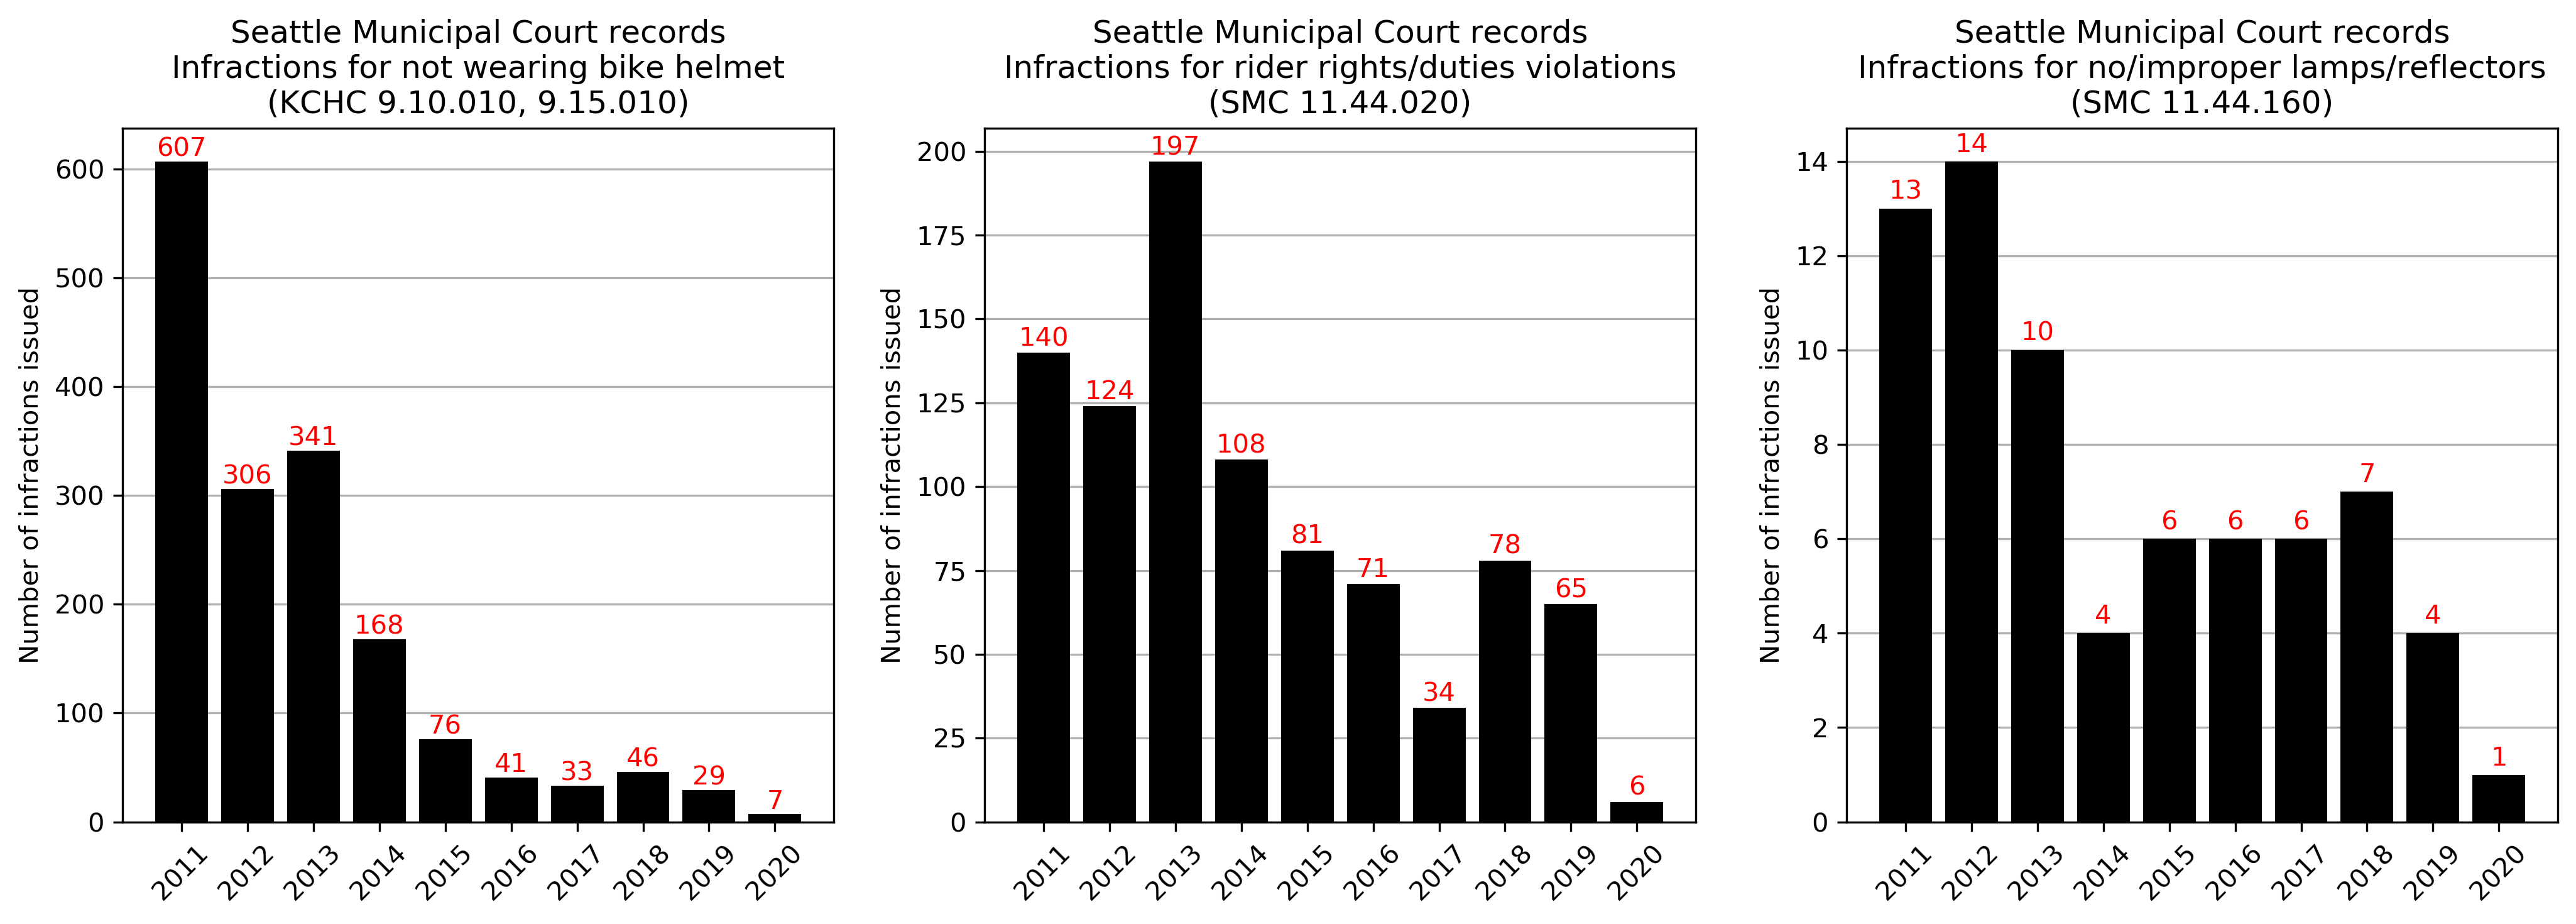

In [4]:
# plot annual data for selected Seattle bike infractions

x = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].index
y = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].values
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nInfractions for not wearing bike helmet\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+5,str(y_val),c='r',fontweight='regular',horizontalalignment='center')

x = seattle_summaries['Rider Rights/Duties Violation (11.44.020)'].index
y = seattle_summaries['Rider Rights/Duties Violation (11.44.020)'].values
plt.subplot(1,3,2)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nInfractions for rider rights/duties violations\n(SMC 11.44.020)')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+2,str(y_val),c='r',fontweight='regular',horizontalalignment='center')
 
x = seattle_summaries['No/Improper Lamps/Reflectors (11.44.160)'].index
y = seattle_summaries['No/Improper Lamps/Reflectors (11.44.160)'].values
plt.subplot(1,3,3)
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
plt.xticks(x,rotation=45)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records\nInfractions for no/improper lamps/reflectors\n(SMC 11.44.160)')
for i, y_val in enumerate(y):
    plt.text(x[i],y_val+0.2,str(y_val),c='r',fontweight='regular',horizontalalignment='center')
plt.tight_layout()

In [5]:
# load all Seattle Municipal Court infraction records
seattle_mc_all = pd.read_excel('/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/2020-07-16 - Seattle Municipal Court bicycle violations (2017-01-01 to 2020-06-30).xlsx',
                               index_col=None,parse_dates=[0,1])
seattle_mc_all['Defendant Race'] = seattle_mc_all['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information
display(seattle_mc_all)

# extract helmet violations into separate sheet
seattle_mc_helmet = seattle_mc_all[seattle_mc_all['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

,Violation Date,Filing Date,Citation Number,Violation Code,Violation Description,Violation Time,Violation Location,Officer First Name,Officer Middle Initial,Officer Last Name,Officer Number,Defendant Race,Defendant Gender
0,2017-01-09,2017-01-10,12915476,KCHC9.10.010,BICYCLE HELMET REQUIRED,1330,NaN,JAMES,NaN,OLSON,7316,U,M
1,2017-01-09,2017-01-10,12915476,KCHC9.10.010,BICYCLE HELMET REQUIRED,1330,NaN,CHRISTOPHER,J,MYERS,7601,U,M
2,2017-01-16,2017-01-17,12922381,SMC11.44.160,BIKE NO/IMPROPER LAMPS/REFLECTORS,638,NaN,JOHN,D,RANDLE,8337,W,M
3,2017-01-15,2017-01-17,12922380,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,542,NaN,JOHN,D,RANDLE,8337,W,M
4,2017-01-29,2017-02-01,12921049,SMC11.44.160,BIKE NO/IMPROPER LAMPS/REFLECTORS,1835,NaN,FRANKLIN,D,POBLOCKI,6613,W,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2020-05-19,2020-06-23,12948137,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1732,NaN,PRESTON,J,TURK,8468,W,M
443,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,ALEX,J,PRATT,7643,W,M
444,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,DAVID,S,WARNOCK,8389,W,M
445,2020-05-01,2020-06-23,12947249,KCHC9.10.010,BICYCLE HELMET REQUIRED,1708,NaN,SEAN,D,CULBERTSON,7662,W,M


In [6]:
# define function to load US Census Bureau American Community Survey (ACS) demographic data

# data obtained from, e.g. for Seattle: https://data.census.gov/cedsci/table?q=Seattle%20city,%20Washington&g=1600000US5363000&hidePreview=true&tid=ACSDP5Y2018.DP05&table=DP05
# note this grouping of racial categories is with probable phenotypical presentation in mind:
#    - 'Black' includes those listed in 'Two or more races' as 'Black and White' and 'Black and Native American'
#    - 'Asian_PacIs' includes those listed in 'Two or more races' as 'Asian and White'
#    - 'NativeAm_AlaskanNat' includes those listed in 'Two or more races' as 'Native American and White'

def load_census(city_abbrev,span,years=arange(2010,2018+1)):
    """
    Args:
        city_abbrev: e.g. 'Seattle', 'Federal_Way', etc.
        span: ACS span in years (1 or 5)
        years: ACS year or years to load (exact year for ACS 1-year or final year for ACS 5-year, e.g. 2010 for 2006-2010)
    """
    root_dir = '/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/2020-07-18 - US Census Bureau American Community Survey (ACS) data/'
    city_dir = '{0}_ACS_{1}_yr/'.format(city_abbrev,span)
    if type(years) == int: years = [years]
    census_data = pd.DataFrame(index=years,columns=['Total_population','Asian_PacIs','Black','NativeAm_AlaskanNat','White','Other'])
    for year in years:
        filename_wildcard = 'ACSDP{0}Y{1}.DP05_data*.csv'.format(span,year)
        filename = glob.glob(root_dir + city_dir + filename_wildcard)[0]
        raw_census_data = pd.read_csv(filename,header=1)
        if 'Percent!!RACE!!One race!!Asian' in raw_census_data.columns:
            header = 'Percent!!RACE!!'
        else:
            header = 'Percent Estimate!!RACE!!Total population!!'
        tot_pop = raw_census_data['Estimate!!RACE!!Total population'].values[0]
        api_percent = raw_census_data[header + 'One race!!Asian'].values[0] + \
                      raw_census_data[header + 'One race!!Native Hawaiian and Other Pacific Islander'].values[0] + \
                      raw_census_data[header + 'Two or more races!!White and Asian'].values[0]
        black_percent = raw_census_data[header + 'One race!!Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!Black or African American and American Indian and Alaska Native'].values[0]
        natam_percent = raw_census_data[header + 'One race!!American Indian and Alaska Native'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and American Indian and Alaska Native'].values[0]
        white_percent = raw_census_data[header + 'One race!!White'].values[0]
        other_percent = 100.0 - api_percent - black_percent - natam_percent - white_percent
        if other_percent < 0.0: print('Uh oh... summed total of racial percentages is greater than 100%')
        census_data.loc[year] = {'Total_population':tot_pop,'Asian_PacIs':api_percent,'Black':black_percent,
                                 'NativeAm_AlaskanNat':natam_percent,'White':white_percent,'Other':other_percent}
    if span == 5: census_data['5_yr_period'] = ['{0}-{1}'.format(yr-4,yr) for yr in census_data.index]
    return census_data

In [7]:
# load racial statistics from SDOT 2013 Bicycle Participation Phone Survey
# data information and access:
#     - https://www.seattle.gov/transportation/projects-and-programs/programs/bike-program/bike-data
#     - https://www.seattle.gov/Documents/Departments/SDOT/BikeProgram/13-5004bikesdotcrosstab.pdf

sdot_survey = pd.read_excel('/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/2020-07-18 - SDOT 2013 Bicycle Participation Phone Survey - racial statistics.xlsx',
                            index_col=0)
sdot_survey

,Percent riding a few times per year,Number riding a few times per year,Percent riding a few times per month or more,Number riding a few times per month or more,Average percent
Race/ethnicity,,,,,
All,100,69.00,100,110.0,100.0
Black,5,3.45,4,4.4,4.5
White,72,49.68,80,88.0,76.0
Hispanic,2,1.38,2,2.2,2.0
Asian,18,12.42,11,12.1,14.5
Other,2,1.38,4,4.4,3.0
Refuse,1,0.69,0,0.0,0.5
White_Hispanic,74,51.06,82,90.2,78.0
Residual,3,2.07,3,3.3,3.0


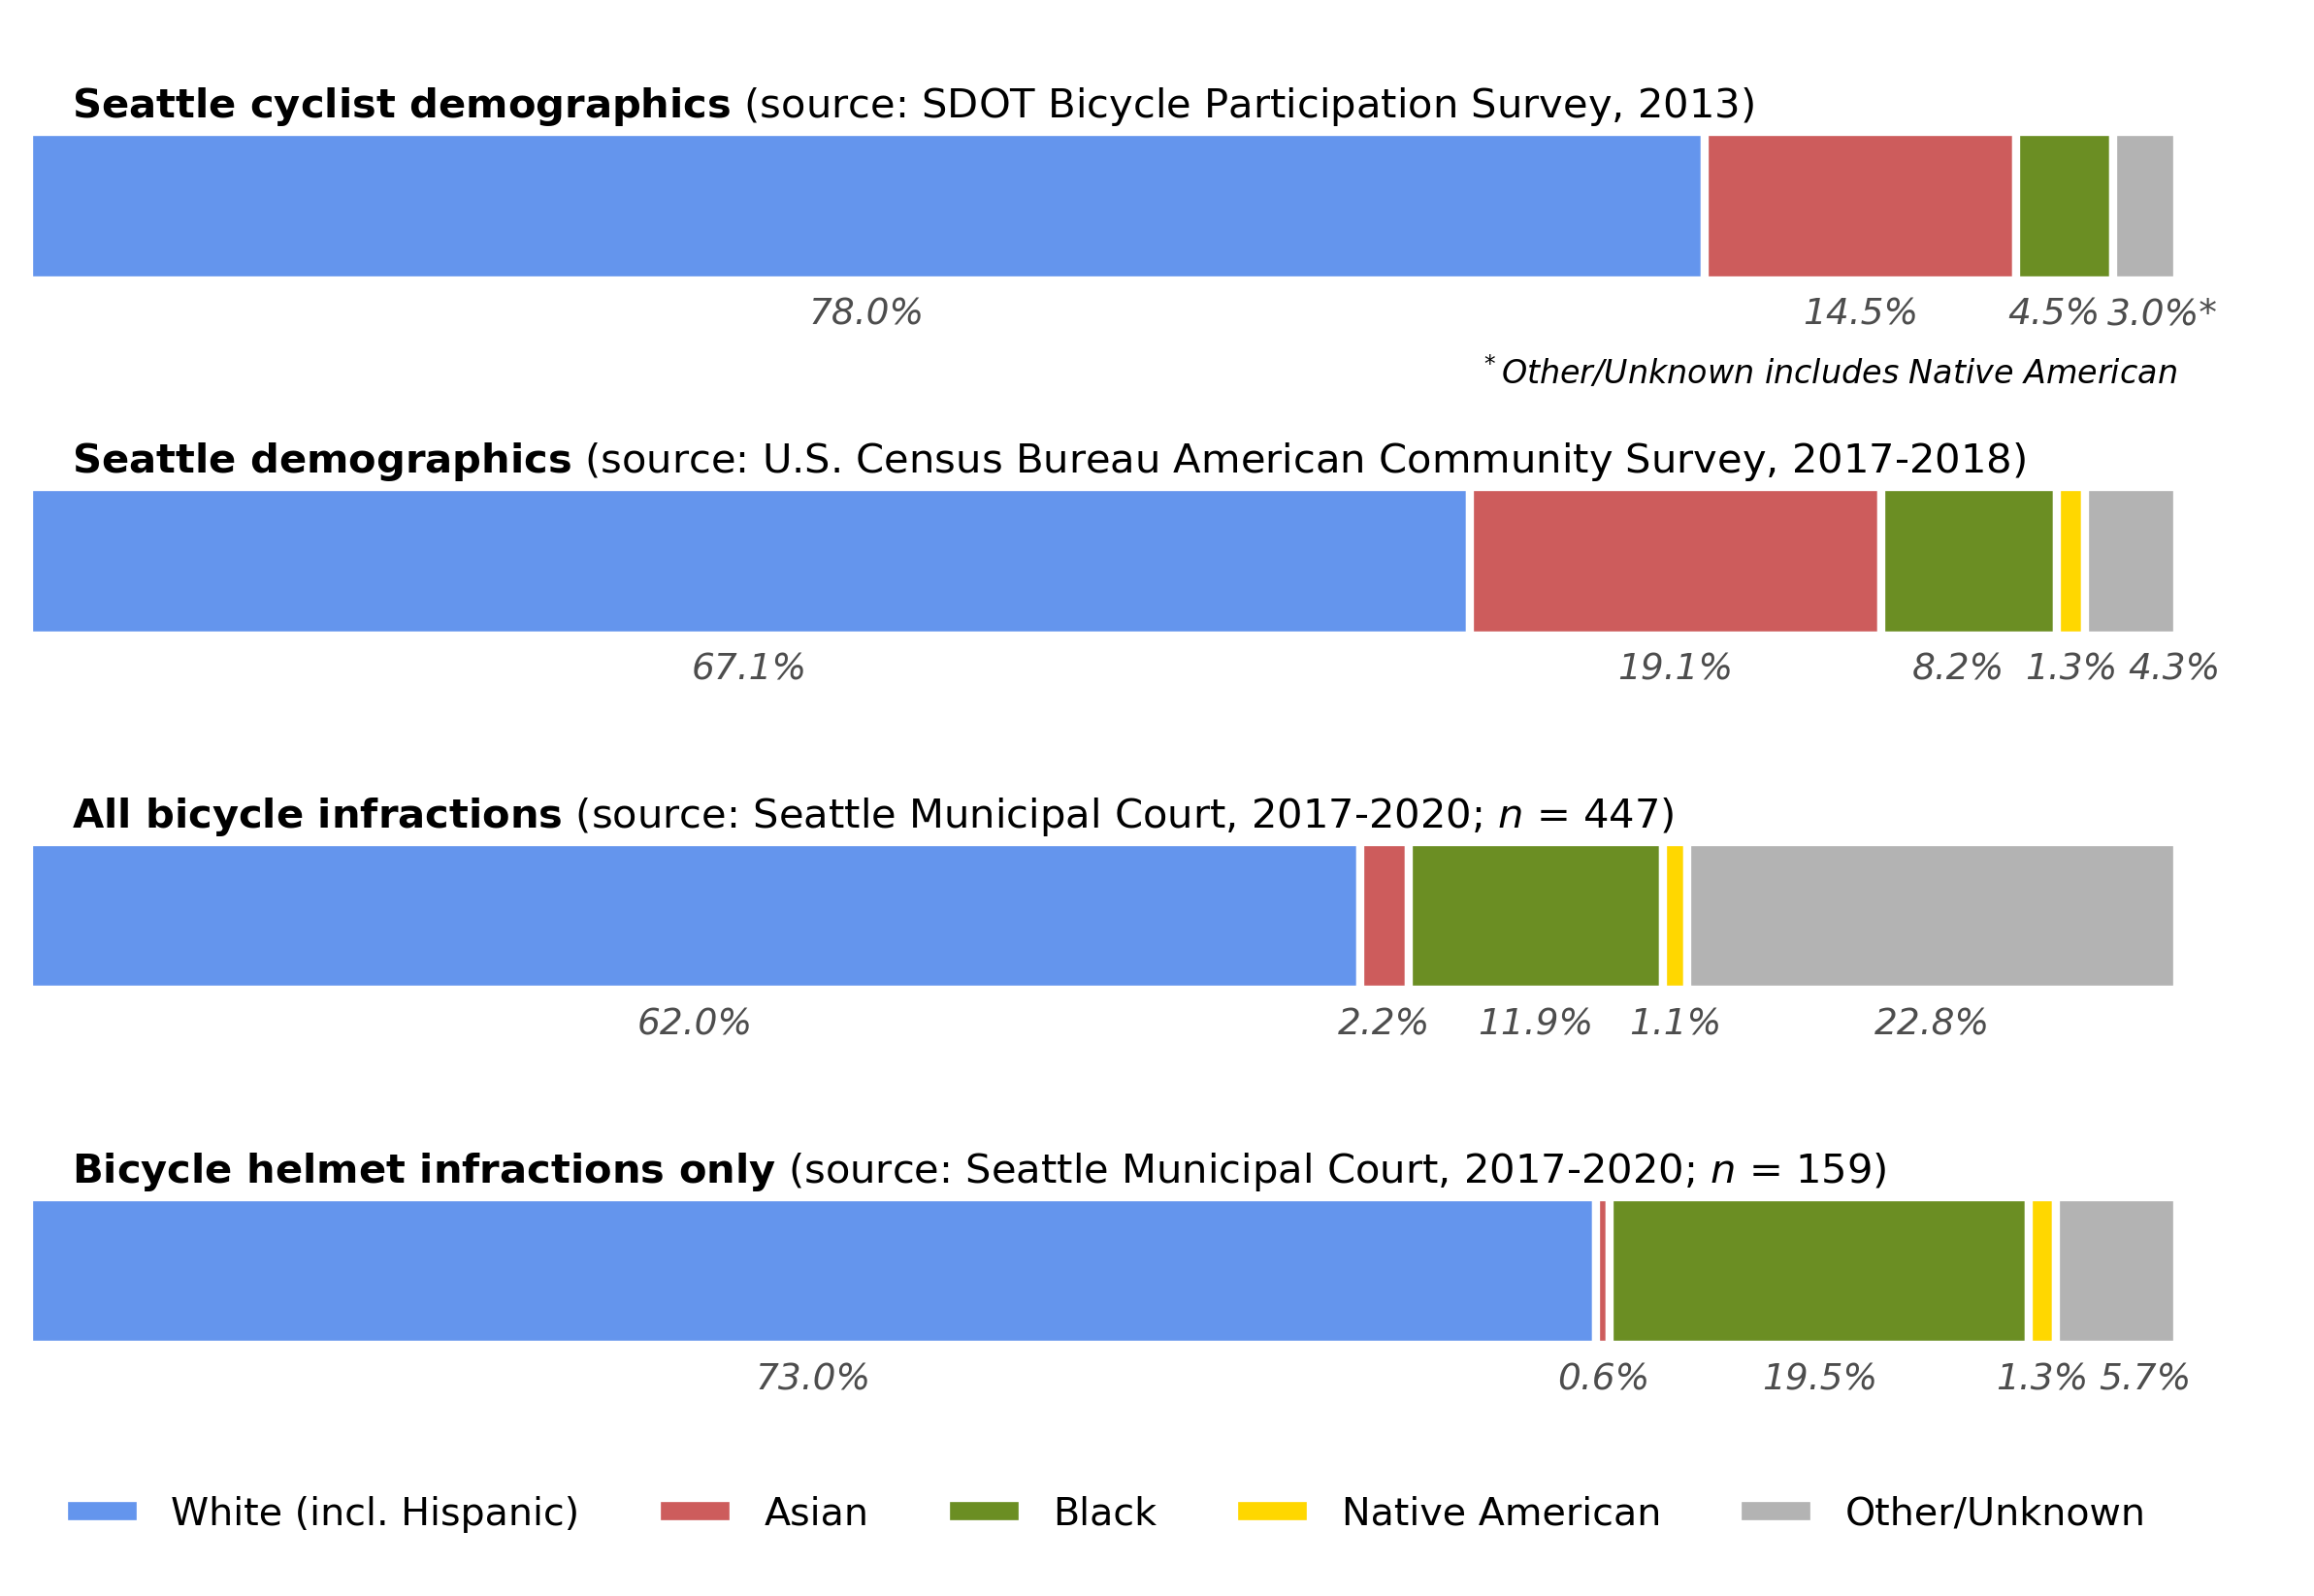

In [8]:
# plot comparison of Seattle bike infraction data, Seattle demographics, and Seattle cyclist demographics

plt.figure(figsize=(10,7))

labels = ['White (incl. Hispanic)','Asian','Black','Other/Unknown']  # Other includes Native American here
colors = ['cornflowerblue','indianred','olivedrab','0.7']
bump_label = [0,0,-.5,.8]
label_star = [0,0,0,1]
y_baseline = 4.6
widths = array([sdot_survey['Average percent'].loc['White_Hispanic'],
                sdot_survey['Average percent'].loc['Asian'],
                sdot_survey['Average percent'].loc['Black'],
                sdot_survey['Average percent'].loc['Residual']])
h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~cyclist~demographics}$ (source: SDOT Bicycle Participation Survey, 2013)')
plt.text(100,y_baseline-0.6,'$^*$Other/Unknown includes Native American',fontstyle='italic',horizontalalignment='right',fontsize=8)

seattle_census = load_census('Seattle',1).loc[2017:2018].mean()
labels = ['White (incl. Hispanic)','Asian','Black','Native American','Other/Unknown']
colors = ['cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,-0.5,0,2.0]
label_star = [0,0,0,0,0]
y_baseline = 3.4
widths = array([seattle_census['White'],
                seattle_census['Asian_PacIs'],
                seattle_census['Black'],
                seattle_census['NativeAm_AlaskanNat'],
                seattle_census['Other']])
h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~demographics}$ (source: U.S. Census Bureau American Community Survey, 2017-2018)')

bump_label = [0,0,0,0,0]
label_star = [0,0,0,0,0]
y_baseline = 2.2
widths = array([100 * sum(seattle_mc_all['Defendant Race'] == 'W') / len(seattle_mc_all),
                100 * sum(seattle_mc_all['Defendant Race'] == 'A') / len(seattle_mc_all),
                100 * sum(seattle_mc_all['Defendant Race'] == 'B') / len(seattle_mc_all),
                100 * sum(seattle_mc_all['Defendant Race'] == 'I') / len(seattle_mc_all),
                100 * sum(seattle_mc_all['Defendant Race'] == 'U') / len(seattle_mc_all)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{All~bicycle~infractions}$ (source: Seattle Municipal Court, 2017-2020; ' \
                          + '$n$ = {0})'.format(len(seattle_mc_all)))

bump_label = [0,0,0,0,1.3]
label_star = [0,0,0,0,0]
y_baseline = 1.0
widths = array([100 * sum(seattle_mc_helmet['Defendant Race'] == 'W') / len(seattle_mc_helmet),
                100 * sum(seattle_mc_helmet['Defendant Race'] == 'A') / len(seattle_mc_helmet),
                100 * sum(seattle_mc_helmet['Defendant Race'] == 'B') / len(seattle_mc_helmet),
                100 * sum(seattle_mc_helmet['Defendant Race'] == 'I') / len(seattle_mc_helmet),
                100 * sum(seattle_mc_helmet['Defendant Race'] == 'U') / len(seattle_mc_helmet)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Bicycle~helmet~infractions~only}$ (source: Seattle Municipal Court, 2017-2020; ' \
                          + '$n$ = {0})'.format(len(seattle_mc_helmet)))
plt.ylim([0,5.2])

plt.legend(h2,labels,ncol=5,frameon=False,loc='lower left',prop={'size':9.5});
plt.xticks([]); plt.yticks([])
plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)

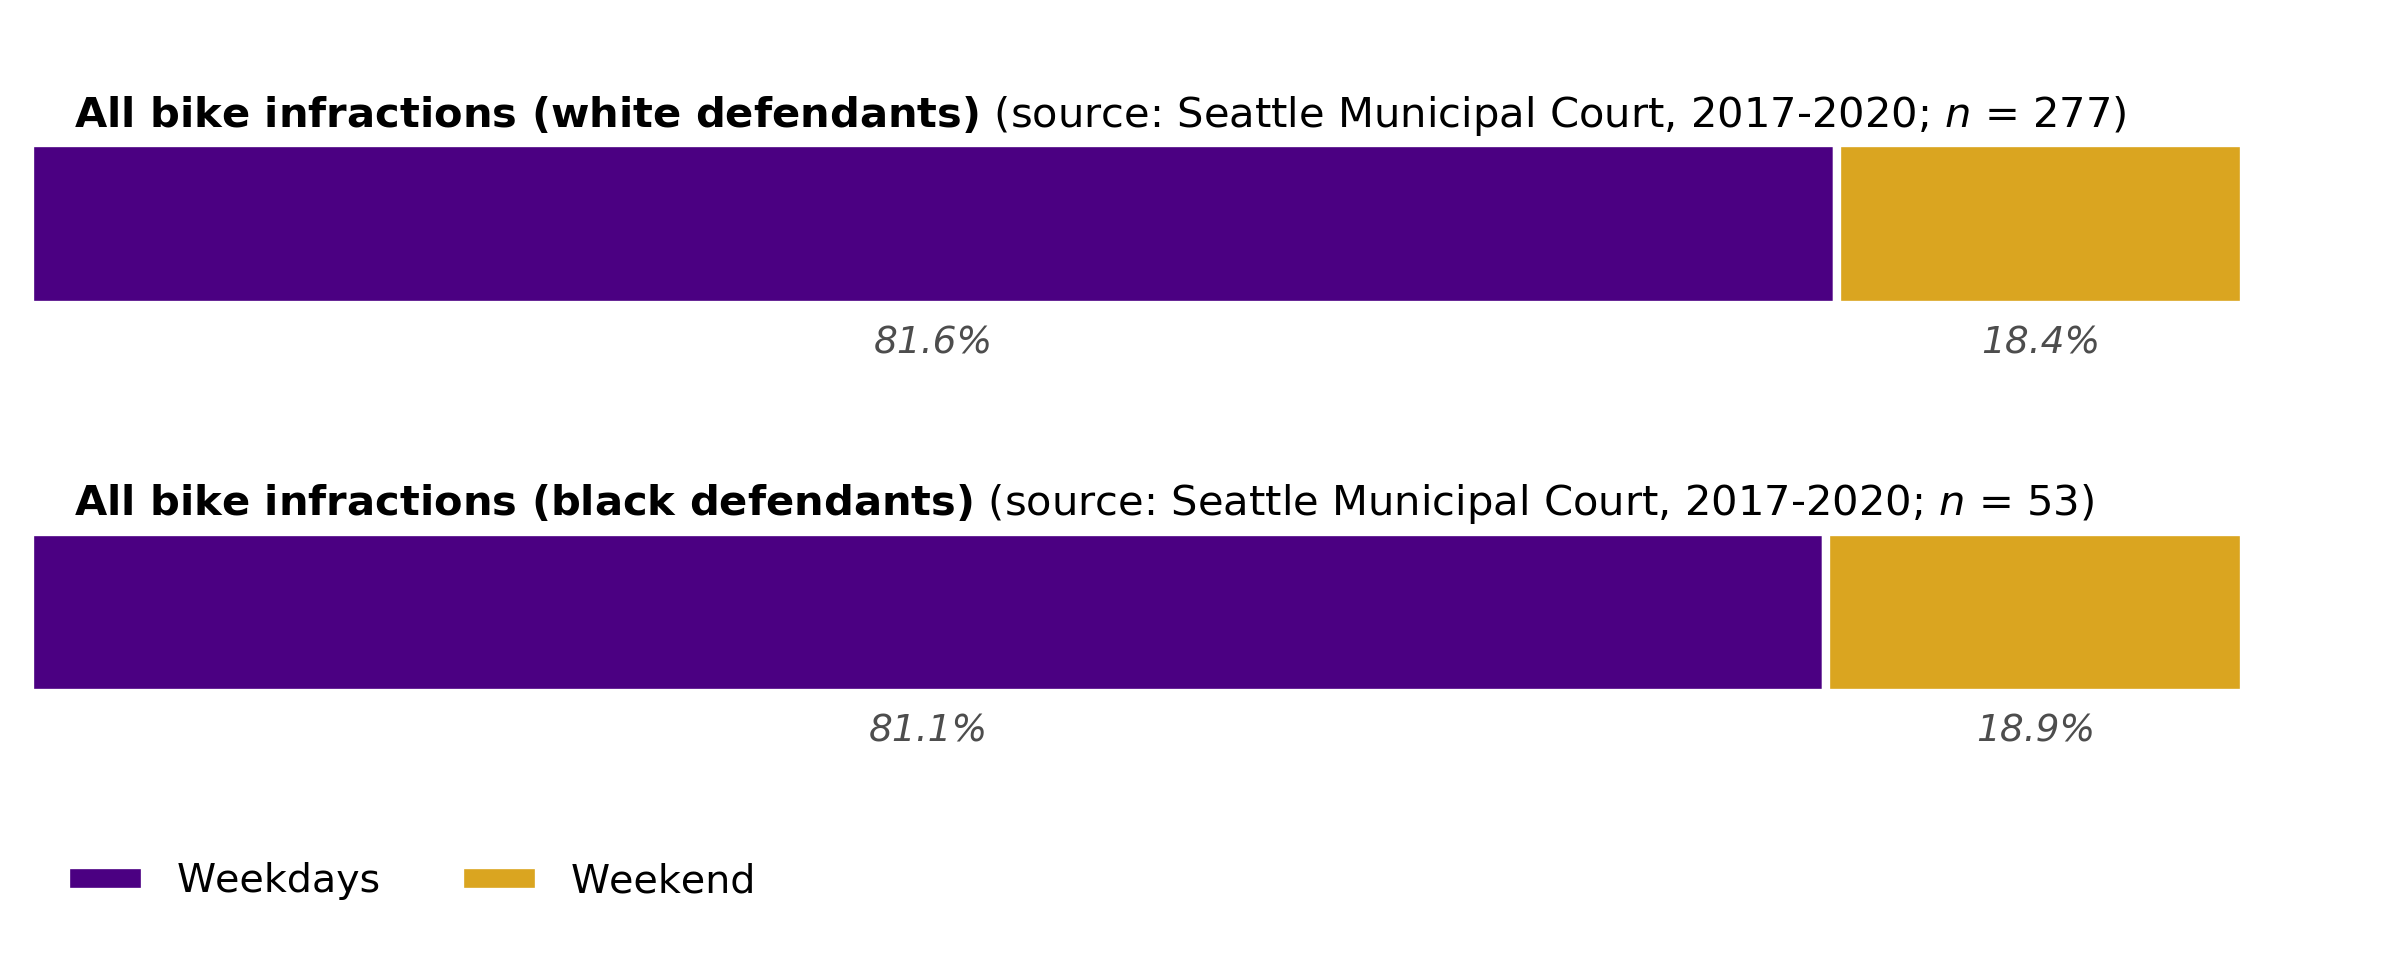

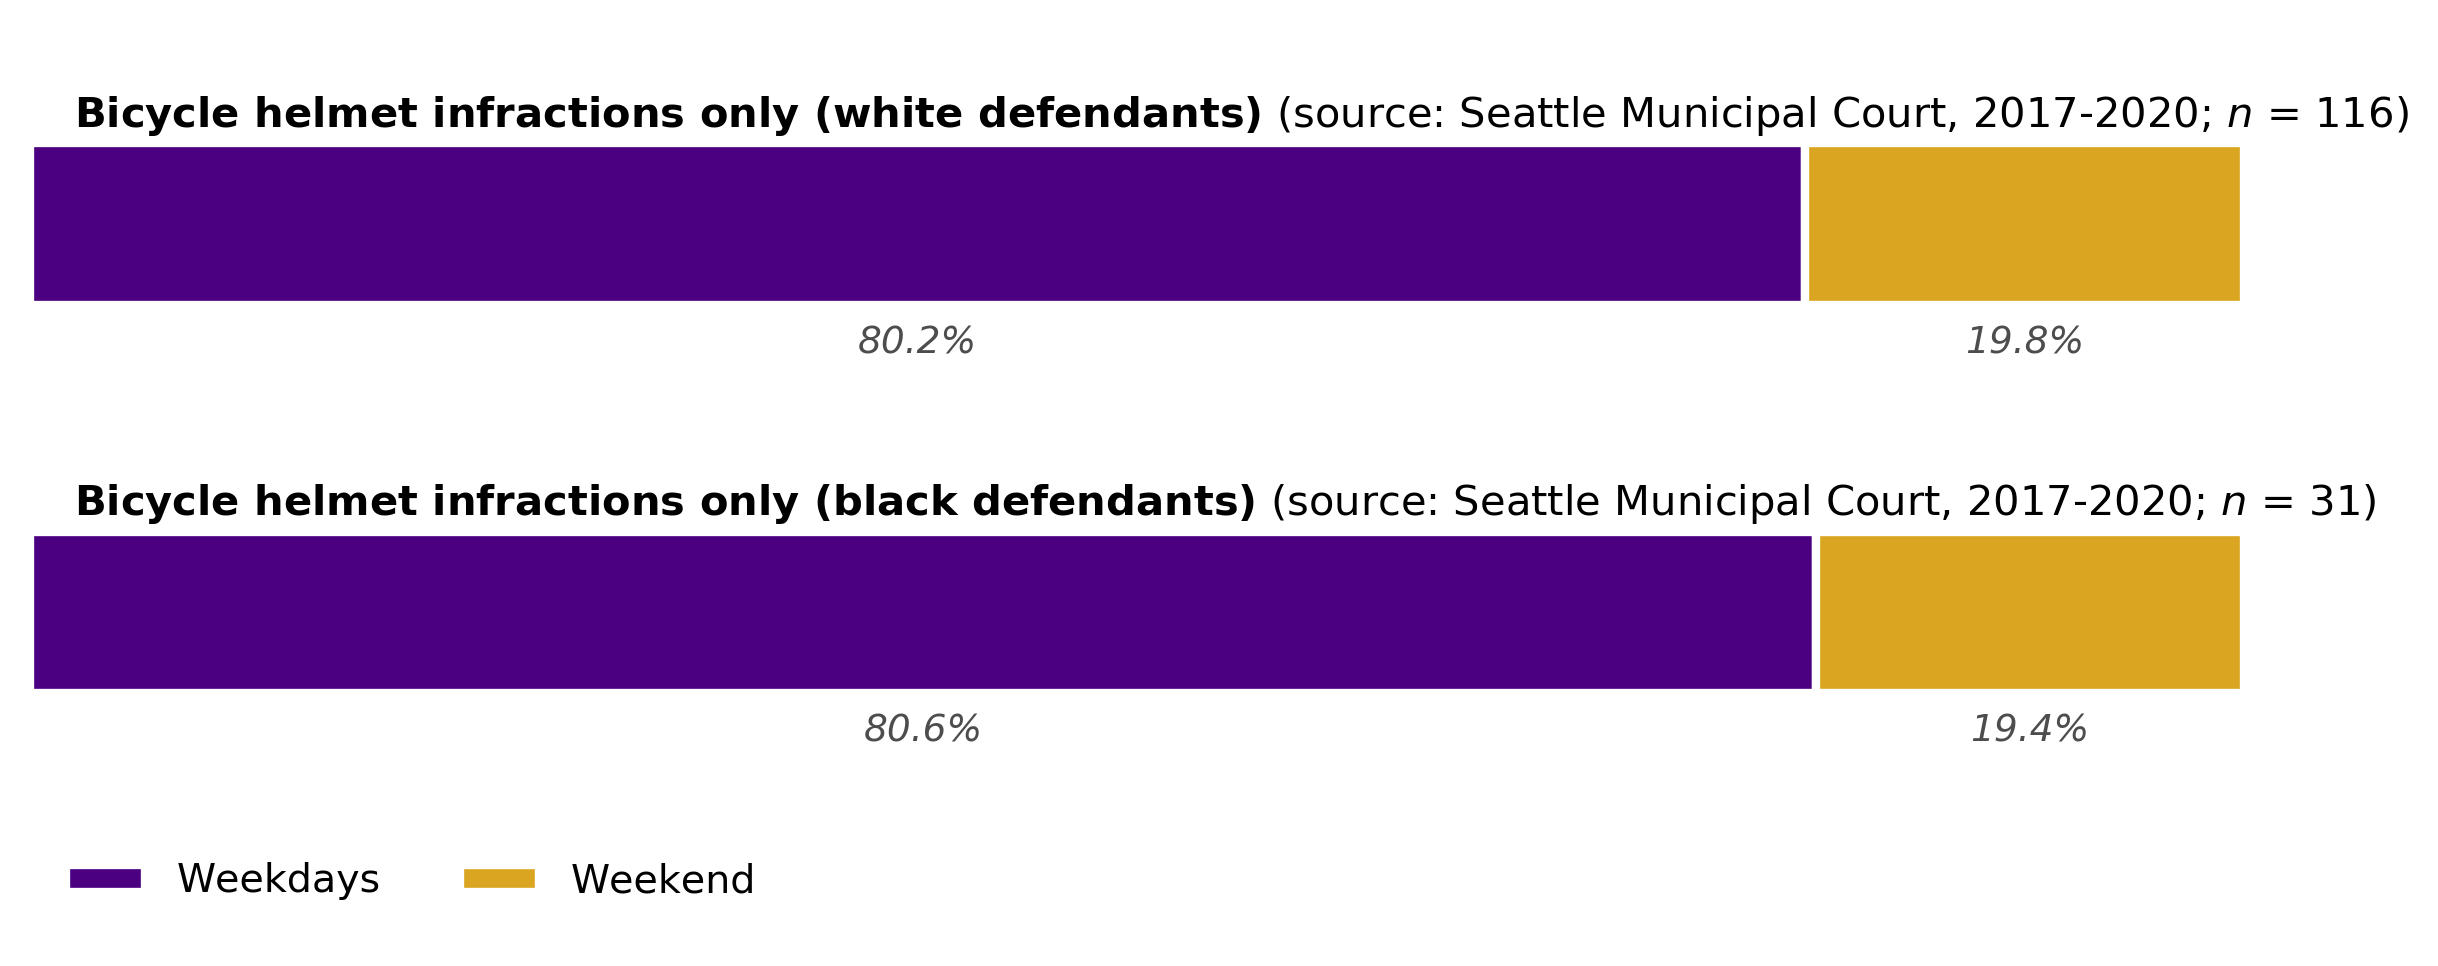

In [68]:
# analysis of weekdays in which infractions were written

dows_all_white = histogram([dt.dayofweek for dt in seattle_mc_all['Violation Date'][seattle_mc_all['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_all_black = histogram([dt.dayofweek for dt in seattle_mc_all['Violation Date'][seattle_mc_all['Defendant Race'] == 'B']],
                           bins=arange(0,8))
dows_helmet_white = histogram([dt.dayofweek for dt in seattle_mc_helmet['Violation Date'][seattle_mc_helmet['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_helmet_black = histogram([dt.dayofweek for dt in seattle_mc_helmet['Violation Date'][seattle_mc_helmet['Defendant Race'] == 'B']],
                           bins=arange(0,8))

which_infractions = [r'$\bf{All~bike~infractions~',r'$\bf{Bicycle~helmet~infractions~only~']
for r_idx, dows in enumerate([[dows_all_white,dows_all_black],[dows_helmet_white,dows_helmet_black]]):
    plt.figure(figsize=(10,4))

    labels = ['Weekdays','Weekend']
    colors = ['indigo','goldenrod']
    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 2.2
    widths = array([100*sum(dows[0][0][0:5])/sum(dows[0][0]),100*sum(dows[0][0][5:7])/sum(dows[0][0])])
    h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(white~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[0][0])))

    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 1.0
    widths = array([100*sum(dows[1][0][0:5])/sum(dows[1][0]),100*sum(dows[1][0][5:7])/sum(dows[1][0])])
    h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(black~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[1][0])))

    plt.ylim([0,2.8])

    plt.legend(h2,labels,ncol=5,frameon=False,loc='lower left',prop={'size':9.5});
    plt.xticks([]); plt.yticks([])
    plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)
